In [1]:
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import re

In [2]:
train_data = pd.read_csv('ratings_train.txt', sep = "\t", engine='python')
test_data = pd.read_csv('ratings_test.txt', sep = "\t", engine='python')

In [3]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
tokenizer = Mecab()
tokenized_sentence = tokenizer.morphs('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아')
#morphs는 형태소 추출 (+nouns: 명사추출, pos: 품사 부착)
tokenized_sentence

['뭐',
 '야',
 '이',
 '평점',
 '들',
 '은',
 '.',
 '...',
 '나쁘',
 '진',
 '않',
 '지만',
 '10',
 '점',
 '짜리',
 '는',
 '더더욱',
 '아니',
 '잖아']

In [6]:
def preprocess_review(sentence):
    sentence = re.sub(r'\([^)]*\)',r'',sentence) #소괄호 내용 삭제
    sentence = re.sub(r'\[[^)]*\]',r'',sentence) #대괄호 내용 삭제
    
    sentence = re.sub(r'["."]{2,}', r" .. ", sentence)#두 개이상의 .을 ..으로 변환
    sentence = re.sub(r'["?"]{2,}', r" ?? ", sentence)#두 개이상의 ?을 ??으로 변환
    sentence = re.sub(r'["!"]{2,}', r" !! ", sentence)#두 개이상의 !을 !!으로 변환
    sentence = re.sub(r'["ㅜ"]{2,}', r" ㅜㅜ ", sentence)#두 개이상의 자음을 2번 반복으로 변환
    sentence = re.sub(r'["ㅠ"]{2,}', r" ㅠㅠ ", sentence)
    sentence = re.sub(r'["ㅋ"]{2,}', r" ㅋㅋ ", sentence)
    sentence = re.sub(r'["ㅎ"]{2,}', r" ㅎㅎ ", sentence)
    sentence = re.sub(r'["ㄱ"]{2,}', r" ㄱㄱ ", sentence)
    sentence = re.sub(r'["ㄷ"]{2,}', r" ㄷㄷ ", sentence)
    sentence = re.sub(r'["ㅅ"]{2,}', r" ㅅㅅ ", sentence)
    sentence = re.sub(r'["ㅊ"]{2,}', r" ㅊㅊ ", sentence)

    sentence = re.sub(r'["ㅈㄴ"]+',"", sentence)
    sentence = re.sub(r'["ㅅㅂ"]+',"", sentence)
    
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣.?!,' ]+","",sentence) #한글 및 지정된 특수문자 외 제거
    sentence = re.sub(r'[" "]+'," ",sentence) #연속된 공백은 공백 하나로 처리
    
    return sentence

In [7]:
 preprocess_review('아..........ㅈㄴ       머냐 정말!@#')

'아 .. 머냐 정말!'

In [8]:
stopwords = ['의','가','이','은', '을','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '겠', '음']

In [9]:
def load_data(train_data, test_data, num_words = 10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data['document'] = train_data['document'].apply(lambda x: preprocess_review(str(x)))
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].apply(lambda x: preprocess_review(str(x)))
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
     temp_X = tokenizer.morphs(sentence) #토큰화
     temp_X = [word for word in temp_X if not word in stopwords] 
     X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
     temp_X = tokenizer.morphs(sentence) #토큰화
     temp_X = [word for word in temp_X if not word in stopwords] 
     X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>','<BOS>','<UNK>','<UNUSED>'] + [key for key, _ in counter]#특수한 토큰에 대해 지정
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>']for word in wordlist]
        #사전에 없는 단어에는 <unk>토큰을 부여
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

#X_train, X_test 각 문장이 형태소별 빈도수로 인코딩된 list
#train_set, test_set의 label은 0,1로 이루어진 np.array

In [10]:
X_train, y_train, X_test, y_test, word_dict = load_data(train_data, test_data)

In [11]:
word_dict #사전의 앞부분

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '보': 9,
 '!': 10,
 ',': 11,
 '게': 12,
 '지': 13,
 '있': 14,
 '?': 15,
 '없': 16,
 '좋': 17,
 '나': 18,
 '었': 19,
 '만': 20,
 '는데': 21,
 '너무': 22,
 '봤': 23,
 '적': 24,
 '안': 25,
 '로': 26,
 '정말': 27,
 '것': 28,
 '아': 29,
 'ㅋㅋ': 30,
 '네요': 31,
 '어': 32,
 '재밌': 33,
 '같': 34,
 '지만': 35,
 '진짜': 36,
 '했': 37,
 '기': 38,
 '에서': 39,
 '네': 40,
 '점': 41,
 '않': 42,
 '거': 43,
 '았': 44,
 '수': 45,
 '되': 46,
 '면': 47,
 '말': 48,
 '인': 49,
 '연기': 50,
 '주': 51,
 '최고': 52,
 '내': 53,
 '평점': 54,
 '이런': 55,
 '던': 56,
 '어요': 57,
 '할': 58,
 '왜': 59,
 '해': 60,
 '스토리': 61,
 '습니다': 62,
 '드라마': 63,
 '아니': 64,
 '생각': 65,
 '더': 66,
 '그': 67,
 '싶': 68,
 '사람': 69,
 '듯': 70,
 '때': 71,
 '감동': 72,
 '함': 73,
 '배우': 74,
 '본': 75,
 '까지': 76,
 '뭐': 77,
 '보다': 78,
 '알': 79,
 '만들': 80,
 '내용': 81,
 '볼': 82,
 '감독': 83,
 '라': 84,
 '그냥': 85,
 '재미': 86,
 '시간': 87,
 '지루': 88,
 '재미있': 89,
 '중': 90,
 '였': 91,
 '년': 92,
 '잼': 93,
 '사랑': 94,
 '못

In [12]:
#문장의 정수인코딩 변호나을 확인하는 작업
z = train_data['document'].iloc[8300]
z

'ㅎ나름 볼만 했어요'

In [13]:
tokenizer.morphs(z)

['ㅎ', '나름', '볼', '만', '했어요']

In [14]:
#padding

total_data_text = list(X_train) + list(X_test)
#텍스트 데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
#문자길이의 평균, 최대, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

#예시로 최대 길이를 '평균+2.2*표준편차'로 가정
max_tokens = np.mean(num_tokens)+2.2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {:.2f}%가 maxlen 설정값 이내에 포함됩니다. ' \
     .format(100 * np.sum(num_tokens < max_tokens)/len(num_tokens))) 

문장길이 평균 :  15.151417265192663
문장길이 최대 :  90
문장길이 표준편차 :  12.285869297870217
pad_sequences maxlen :  42
전체 문장의 94.40%가 maxlen 설정값 이내에 포함됩니다. 


In [15]:
import tensorflow as tf
from tensorflow import keras
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_dict["<PAD>"],
                                                        padding='pre', #of post
                                                        maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word_dict["<PAD>"],
                                                        padding='pre', #of post
                                                        maxlen=maxlen)
print(X_train.shape)

(146183, 42)


In [16]:
X_train[8300]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  287,  377,   82,   20, 2726], dtype=int32)

In [19]:
from sklearn.model_selection import train_test_split

import tensorflow_addons as tfa
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2

#train_set 을 train과 val로 분해
X_train, X_trainval, y_train, y_trainval = train_test_split(
    X_train, y_train, test_size=0.25)

vocab_size = 10000 #vacab dict size(10,000개 단어)
word_vector_dim = 256

lnLSTMCell = tfa.rnn.LayerNormLSTMCell(20, recurrent_dropout=0.2, dropout=0.3, kernel_regularizer=l2(0.015), recurrent_regularizer=l2(0.015))
rnn = tf.keras.layers.RNN(lnLSTMCell, return_sequences=False, return_state=False)

#model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(rnn)
model.add(keras.layers.Dense(15, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(keras.layers.Dense(1, activation='sigmoid')) #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2560000   
_________________________________________________________________
rnn (RNN)                    (None, 20)                22520     
_________________________________________________________________
dense (Dense)                (None, 15)                315       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 2,582,851
Trainable params: 2,582,851
Non-trainable params: 0
_________________________________________________________________


In [22]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min'),
             tf.keras.callbacks.ModelCheckpoint(filepath='biggr_model.h5',
                                                monitor='val_loss',
                                                save_best_only=True)]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=15

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_trainval, y_trainval),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/15
215/215 [==============================] - 47s 221ms/step - loss: 1.3023 - accuracy: 0.7582 - val_loss: 0.6310 - val_accuracy: 0.8363
Epoch 2/15
215/215 [==============================] - 47s 220ms/step - loss: 0.5014 - accuracy: 0.8542 - val_loss: 0.4601 - val_accuracy: 0.8414
Epoch 3/15
215/215 [==============================] - 47s 219ms/step - loss: 0.3859 - accuracy: 0.8708 - val_loss: 0.4066 - val_accuracy: 0.8506
Epoch 4/15
215/215 [==============================] - 47s 220ms/step - loss: 0.3366 - accuracy: 0.8815 - val_loss: 0.4029 - val_accuracy: 0.8493
Epoch 5/15
215/215 [==============================] - 46s 214ms/step - loss: 0.3062 - accuracy: 0.8923 - val_loss: 0.4347 - val_accuracy: 0.8334


In [23]:
#test_set 을 test과 val로 분해
X_test, X_testval, y_test, y_testval = train_test_split(X_test, y_test, test_size=0.25)


In [24]:
model.evaluate(X_testval, y_testval)

385/385 [==============================] - 11s 28ms/step - loss: 0.4317 - accuracy: 0.8335


[0.4316657781600952, 0.8335232138633728]

In [25]:
model.evaluate(X_test, y_test)

1153/1153 [==============================] - 33s 29ms/step - loss: 0.4322 - accuracy: 0.8346


[0.4321713447570801, 0.8346262574195862]

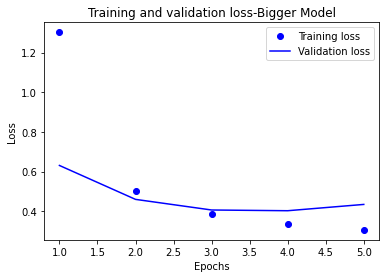

In [29]:
history_dict=history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
#bo는 점, b는 선
plt.plot(epochs, loss, 'bo',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss-Bigger Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

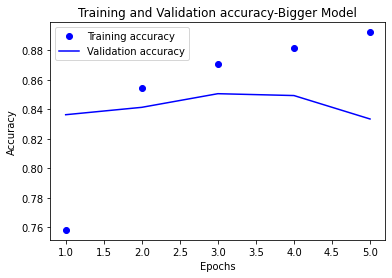

In [30]:
plt.clf() #초기화

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy-Bigger Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [35]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 256)


In [48]:
def encode_sentence(sentence_list):
    X=[]
    for sentence in sentence_list:
        sentence = preprocess_review(sentence) #전처리
        temp_X = tokenizer.morphs(sentence)#형태로 분리
        temp_X = [word for word in temp_X if not word in stopwords]#불용어 처리
        X.append(temp_X) #모으기
        
    encoded_sentences = list(map(wordlist_to_indexlist, X))#정수인코딩
    return encoded_sentences

def wordlist_to_indexlist(wordlist): #training에 사용한 '사전'을 word_dict자리에 넣음
    return [word_dict[word] if word in word_dict else word_dict['<UNK>'] for word in wordlist ]

In [51]:
def predict_sentence(sentence_list): #불러온 모델에 문장 리스트를 넣어 예측값을 이해하기 쉬운 형태로 출력
    encoded_list = encode_sentence(sentence_list)
    padded_list = tf.keras.preprocessing.sequence.pad_sequences(encoded_list,
                                                                value=word_dict["<PAD>"],
                                                                padding='pre', #혹은 'post',
                                                                maxlen=maxlen)
    score_list = model.predict(padded_list)
    for sentence, score in zip(sentence_list, score_list):
        if(score > 0.5):
            print(f"문장 : {sentence}\n {float(score) * 100:.2f}% 확률로 긍정 리뷰입니다. \n")
        else:
            print(f"문장 : {sentence}\n {float(score) * 100:.2f}% 확률로 부정 리뷰입니다. \n")

In [52]:
predict_sentence(['별 재미도없는거 우려먹어 .... 챔프에서 방송 몇번했더라 ? ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ','꽤 재밌게 본 영화였다!', '북괴는 우리의 주적일뿐이다' ])ㅠ

문장 : 별 재미도없는거 우려먹어 .... 챔프에서 방송 몇번했더라 ? ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ
 2.82% 확률로 부정 리뷰입니다. 

문장 : 꽤 재밌게 본 영화였다!
 97.97% 확률로 긍정 리뷰입니다. 

문장 : 북괴는 우리의 주적일뿐이다
 52.60% 확률로 긍정 리뷰입니다. 



In [53]:
predict_sentence(['액션이 진짜 꽤 괜찮았다. ㅎ', '두말할필요없다 이건 보지마 시간이 남으면 집에서 발닦고 잠이나 자라', '한회 한회 보면서 총체적으로 발연기다. 중량급 연기자들도 모두 하향 평준화되는듯. 작가의 생각도 너무 어이업슴. 일일극 치고는 최악으로 평점 1점도 아깝다.	'])

문장 : 액션이 진짜 꽤 괜찮았다. ㅎ
 98.14% 확률로 긍정 리뷰입니다. 

문장 : 두말할필요없다 이건 보지마 시간이 남으면 집에서 발닦고 잠이나 자라
 61.52% 확률로 긍정 리뷰입니다. 

문장 : 한회 한회 보면서 총체적으로 발연기다. 중량급 연기자들도 모두 하향 평준화되는듯. 작가의 생각도 너무 어이업슴. 일일극 치고는 최악으로 평점 1점도 아깝다.	
 2.23% 확률로 부정 리뷰입니다. 

